In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('../')
print(os.getcwd())

/home/vadim/projects/MeteoFill


In [2]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry


/tmp/ipykernel_6956/2280234910.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [6]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client()


# url = "https://api.open-meteo.com/v1/forecast" 		----- FOR FORECASTING
url = "https://archive-api.open-meteo.com/v1/archive" # ----- ARCHIVE DATA


params = {
	"latitude": -74.0411, # North Pole
	"longitude": 51.4071, # North Pole
	"start_date": "2021-07-01",
	"end_date": "2021-07-10",
	"hourly": ["temperature_2m", "relative_humidity_2m", "surface_pressure", "wind_speed_10m", "wind_direction_10m"], # Our params
	"timeformat": "unixtime"
}

responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
# print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
# print(f"Elevation {response.Elevation()} m asl")
# print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
# print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

hourly = response.Hourly()
hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
# Process hourly data. The order of variables needs to be the same as requested.
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_surface_pressure = hourly.Variables(2).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(3).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(4).ValuesAsNumpy()

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["surface_pressure"] = hourly_surface_pressure
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["hourly_wind_direction_10m"] = hourly_wind_direction_10m

hourly_dataframe = pd.DataFrame(data = hourly_data)
hourly_dataframe.set_index("date", drop=True, inplace=True)
hourly_dataframe

,temperature_2m,relative_humidity_2m,surface_pressure,wind_speed_10m,hourly_wind_direction_10m
date,,,,,
2021-07-01 00:00:00+00:00,-55.943501,63.008278,624.190918,26.081993,206.211319
2021-07-01 01:00:00+00:00,-56.193501,62.130650,624.546509,25.318008,209.845840
2021-07-01 02:00:00+00:00,-56.393501,61.670197,624.780396,25.762016,213.023880
2021-07-01 03:00:00+00:00,-56.493500,61.243488,624.772888,26.758923,213.476303
2021-07-01 04:00:00+00:00,-56.493500,61.637867,624.834961,26.980793,211.357025
...,...,...,...,...,...
2021-07-10 19:00:00+00:00,-48.093498,64.230606,631.609497,23.584808,148.736328
2021-07-10 20:00:00+00:00,-48.043499,64.245338,632.049988,23.966375,147.264786
2021-07-10 21:00:00+00:00,-48.143501,64.973602,632.178772,24.363249,145.840256


<Axes: xlabel='date'>

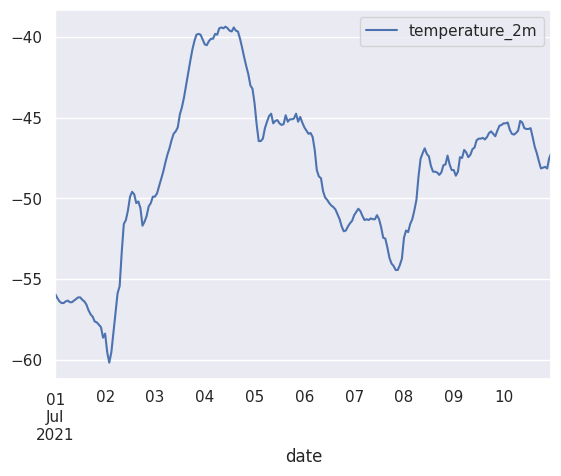

In [7]:
import seaborn as sns
sns.set_theme()

hourly_dataframe.plot(x="date", y="temperature_2m")